In [1]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import tensorflow
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix

2023-03-08 11:25:22.855988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 11:25:22.856010: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
allData = pd.read_csv('../feature_data/features.csv')
allData.replace([np.inf, -np.inf], np.nan, inplace=True)
allData = allData.dropna()
X = allData.drop(["label"],axis=1)
X = X.drop(["radius"],axis=1)
cols = X.keys()

#normalize data
X = preprocessing.normalize(X, norm='max')

#labels
y = allData["label"]

#features
X = pd.DataFrame(X, columns = cols)

X['label'] = y


X = pd.DataFrame(X, columns = cols)


In [3]:
X.describe()

,num_points,std,avg_median_dev,width,linearity,circularity,boundary_length,boundary_regularity,mean_curvature,ang_diff,iav,std_iav,distance,dist_num_points,occluded_right,occluded_left
count,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9.489000e+03,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000
mean,0.591876,0.006595,0.005354,0.018044,0.080554,1.073564e-03,0.021039,0.001622,0.746893,0.131135,0.155018,0.123128,0.264434,0.053376,0.051616,0.044787
std,0.301662,0.006057,0.004928,0.017596,0.216024,4.462697e-03,0.018928,0.002130,0.356924,0.085117,0.096798,0.118237,0.311487,0.089121,0.056148,0.053842
min,0.013108,0.000091,0.000083,0.000258,0.000003,2.989823e-16,0.000450,0.000004,0.001178,0.000784,0.000784,0.000072,0.000755,0.000003,0.000000,0.000000
25%,0.324496,0.001434,0.001189,0.003823,0.000417,8.500852e-06,0.005043,0.000228,0.410400,0.064074,0.077845,0.037257,0.041221,0.002814,0.012499,0.000000
50%,0.515469,0.004599,0.003765,0.011499,0.001413,3.110597e-05,0.014725,0.000697,1.000000,0.109722,0.136684,0.074860,0.114122,0.011405,0.033159,0.027403
75%,1.000000,0.010100,0.007916,0.026915,0.035819,2.910429e-04,0.032701,0.002027,1.000000,0.179543,0.211140,0.182841,0.375337,0.057234,0.072341,0.061478
max,1.000000,0.037908,0.029587,0.096485,1.000000,1.014070e-01,0.100089,0.019309,1.000000,0.448640,0.663490,0.792277,1.000000,0.333334,0.333333,0.333333


<AxesSubplot:>

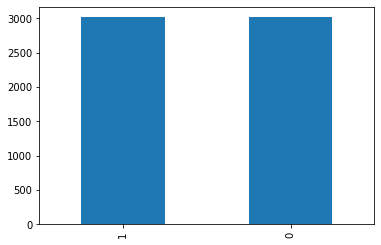

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
y_train.value_counts().plot.bar()


#oversample the minority
ros = RandomOverSampler(sampling_strategy="minority")
X_train, y_train = ros.fit_resample(X_train, y_train)

y_train.value_counts().plot.bar()

In [5]:
def CNN_Model(filters1 = 32, filters2=64, kernel_size=3,strides=1, pool_size=4, optimizer = 'adam'):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=filters1, kernel_size=kernel_size, strides=strides, activation='relu',input_shape=(16,1)))
    model.add(layers.MaxPooling1D(pool_size=pool_size,strides=strides))
    model.add(layers.Conv1D(filters=filters2, kernel_size=kernel_size, strides=strides, activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(2))
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model
    

In [6]:
ms = []
hs = []
for p in [3,4,5]:
    for k in [4,6]:
        for s in [1]:
            if not (s==2 and k==4):
                print(k)
                print(s)
                model = CNN_Model(filters1=64, filters2 = 64,kernel_size=k,strides=s, pool_size=p)
                model.summary()
                ms.append(model)
                history = model.fit(X_train, y_train, epochs=150, 
                                validation_data=(X_val, y_val))
                hs.append(history)


4
1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 64)            320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 64)             16448     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                    

2023-03-08 11:25:34.812936: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-08 11:25:34.812982: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pedrod33): /proc/driver/nvidia/version does not exist
2023-03-08 11:25:34.814517: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


189/189 [==============================] - 1s 4ms/step - loss: 0.2978 - accuracy: 0.8786 - val_loss: 0.2093 - val_accuracy: 0.9162
Epoch 2/150
189/189 [==============================] - 1s 3ms/step - loss: 0.2104 - accuracy: 0.9134 - val_loss: 0.1818 - val_accuracy: 0.9231
Epoch 3/150
189/189 [==============================] - 1s 3ms/step - loss: 0.1781 - accuracy: 0.9231 - val_loss: 0.1577 - val_accuracy: 0.9415
Epoch 4/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1643 - accuracy: 0.9297 - val_loss: 0.1344 - val_accuracy: 0.9399
Epoch 5/150
189/189 [==============================] - 1s 3ms/step - loss: 0.1525 - accuracy: 0.9318 - val_loss: 0.1298 - val_accuracy: 0.9463
Epoch 6/150
189/189 [==============================] - 1s 3ms/step - loss: 0.1415 - accuracy: 0.9367 - val_loss: 0.1231 - val_accuracy: 0.9536
Epoch 7/150
189/189 [==============================] - 1s 3ms/step - loss: 0.1404 - accuracy: 0.9375 - val_loss: 0.1174 - val_accuracy: 0.9510
Epoch 8/150

189/189 [==============================] - 1s 4ms/step - loss: 0.1033 - accuracy: 0.9542 - val_loss: 0.0951 - val_accuracy: 0.9589
Epoch 59/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1011 - accuracy: 0.9569 - val_loss: 0.1082 - val_accuracy: 0.9615
Epoch 60/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1035 - accuracy: 0.9527 - val_loss: 0.0899 - val_accuracy: 0.9663
Epoch 61/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1014 - accuracy: 0.9579 - val_loss: 0.0988 - val_accuracy: 0.9647
Epoch 62/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1020 - accuracy: 0.9556 - val_loss: 0.0944 - val_accuracy: 0.9579
Epoch 63/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1037 - accuracy: 0.9582 - val_loss: 0.1009 - val_accuracy: 0.9589
Epoch 64/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1040 - accuracy: 0.9531 - val_loss: 0.1005 - val_accuracy: 0.9631
Epoch

Epoch 115/150
189/189 [==============================] - 1s 5ms/step - loss: 0.0855 - accuracy: 0.9614 - val_loss: 0.0928 - val_accuracy: 0.9642
Epoch 116/150
189/189 [==============================] - 1s 5ms/step - loss: 0.0864 - accuracy: 0.9627 - val_loss: 0.0936 - val_accuracy: 0.9626
Epoch 117/150
189/189 [==============================] - 1s 5ms/step - loss: 0.0866 - accuracy: 0.9622 - val_loss: 0.0917 - val_accuracy: 0.9652
Epoch 118/150
189/189 [==============================] - 1s 5ms/step - loss: 0.0860 - accuracy: 0.9642 - val_loss: 0.0955 - val_accuracy: 0.9642
Epoch 119/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0846 - accuracy: 0.9638 - val_loss: 0.0998 - val_accuracy: 0.9626
Epoch 120/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0856 - accuracy: 0.9624 - val_loss: 0.0887 - val_accuracy: 0.9652
Epoch 121/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0862 - accuracy: 0.9625 - val_loss: 0.1422 - val_ac

Epoch 13/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1313 - accuracy: 0.9443 - val_loss: 0.1287 - val_accuracy: 0.9542
Epoch 14/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1276 - accuracy: 0.9430 - val_loss: 0.1103 - val_accuracy: 0.9584
Epoch 15/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1243 - accuracy: 0.9444 - val_loss: 0.1159 - val_accuracy: 0.9589
Epoch 16/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1276 - accuracy: 0.9410 - val_loss: 0.1100 - val_accuracy: 0.9573
Epoch 17/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1261 - accuracy: 0.9449 - val_loss: 0.1446 - val_accuracy: 0.9394
Epoch 18/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1225 - accuracy: 0.9469 - val_loss: 0.1215 - val_accuracy: 0.9463
Epoch 19/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1276 - accuracy: 0.9461 - val_loss: 0.1245 - val_accuracy:

Epoch 70/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0889 - accuracy: 0.9630 - val_loss: 0.0944 - val_accuracy: 0.9658
Epoch 71/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0888 - accuracy: 0.9663 - val_loss: 0.0993 - val_accuracy: 0.9668
Epoch 72/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0871 - accuracy: 0.9645 - val_loss: 0.0925 - val_accuracy: 0.9658
Epoch 73/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0852 - accuracy: 0.9662 - val_loss: 0.0954 - val_accuracy: 0.9621
Epoch 74/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0879 - accuracy: 0.9635 - val_loss: 0.1010 - val_accuracy: 0.9668
Epoch 75/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0848 - accuracy: 0.9662 - val_loss: 0.0942 - val_accuracy: 0.9636
Epoch 76/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0887 - accuracy: 0.9657 - val_loss: 0.0941 - val_accuracy:

Epoch 127/150
189/189 [==============================] - 1s 3ms/step - loss: 0.0612 - accuracy: 0.9738 - val_loss: 0.1297 - val_accuracy: 0.9615
Epoch 128/150
189/189 [==============================] - 1s 3ms/step - loss: 0.0657 - accuracy: 0.9718 - val_loss: 0.1205 - val_accuracy: 0.9658
Epoch 129/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0657 - accuracy: 0.9728 - val_loss: 0.1276 - val_accuracy: 0.9610
Epoch 130/150
189/189 [==============================] - 1s 3ms/step - loss: 0.0644 - accuracy: 0.9741 - val_loss: 0.1232 - val_accuracy: 0.9600
Epoch 131/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0635 - accuracy: 0.9731 - val_loss: 0.1173 - val_accuracy: 0.9642
Epoch 132/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0662 - accuracy: 0.9721 - val_loss: 0.1128 - val_accuracy: 0.9663
Epoch 133/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0600 - accuracy: 0.9756 - val_loss: 0.1244 - val_ac

Epoch 25/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1280 - accuracy: 0.9430 - val_loss: 0.1097 - val_accuracy: 0.9552
Epoch 26/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1250 - accuracy: 0.9471 - val_loss: 0.1156 - val_accuracy: 0.9499
Epoch 27/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1226 - accuracy: 0.9464 - val_loss: 0.1209 - val_accuracy: 0.9468
Epoch 28/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1222 - accuracy: 0.9441 - val_loss: 0.1221 - val_accuracy: 0.9568
Epoch 29/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1194 - accuracy: 0.9502 - val_loss: 0.1159 - val_accuracy: 0.9573
Epoch 30/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1206 - accuracy: 0.9488 - val_loss: 0.1228 - val_accuracy: 0.9473
Epoch 31/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1195 - accuracy: 0.9489 - val_loss: 0.1107 - val_accuracy:

Epoch 82/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1022 - accuracy: 0.9544 - val_loss: 0.0999 - val_accuracy: 0.9663
Epoch 83/150
189/189 [==============================] - 1s 3ms/step - loss: 0.1045 - accuracy: 0.9537 - val_loss: 0.0966 - val_accuracy: 0.9579
Epoch 84/150
189/189 [==============================] - 1s 6ms/step - loss: 0.1042 - accuracy: 0.9534 - val_loss: 0.0970 - val_accuracy: 0.9594
Epoch 85/150
189/189 [==============================] - 1s 5ms/step - loss: 0.1030 - accuracy: 0.9547 - val_loss: 0.0923 - val_accuracy: 0.9668
Epoch 86/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1026 - accuracy: 0.9556 - val_loss: 0.0919 - val_accuracy: 0.9631
Epoch 87/150
189/189 [==============================] - 1s 5ms/step - loss: 0.1009 - accuracy: 0.9564 - val_loss: 0.0905 - val_accuracy: 0.9636
Epoch 88/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1011 - accuracy: 0.9534 - val_loss: 0.0940 - val_accuracy:

189/189 [==============================] - 1s 4ms/step - loss: 0.1123 - accuracy: 0.9507 - val_loss: 0.1137 - val_accuracy: 0.9484
Epoch 37/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1068 - accuracy: 0.9534 - val_loss: 0.1028 - val_accuracy: 0.9626
Epoch 38/150
189/189 [==============================] - 1s 3ms/step - loss: 0.1075 - accuracy: 0.9544 - val_loss: 0.0949 - val_accuracy: 0.9658
Epoch 39/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1040 - accuracy: 0.9536 - val_loss: 0.1191 - val_accuracy: 0.9626
Epoch 40/150
189/189 [==============================] - 1s 3ms/step - loss: 0.1060 - accuracy: 0.9534 - val_loss: 0.1027 - val_accuracy: 0.9626
Epoch 41/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1033 - accuracy: 0.9547 - val_loss: 0.1033 - val_accuracy: 0.9557
Epoch 42/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1065 - accuracy: 0.9537 - val_loss: 0.1161 - val_accuracy: 0.9594
Epoch

Epoch 93/150
189/189 [==============================] - 1s 7ms/step - loss: 0.0818 - accuracy: 0.9663 - val_loss: 0.0965 - val_accuracy: 0.9658
Epoch 94/150
189/189 [==============================] - 1s 6ms/step - loss: 0.0825 - accuracy: 0.9677 - val_loss: 0.0991 - val_accuracy: 0.9636
Epoch 95/150
189/189 [==============================] - 1s 6ms/step - loss: 0.0824 - accuracy: 0.9657 - val_loss: 0.1138 - val_accuracy: 0.9615
Epoch 96/150
189/189 [==============================] - 1s 5ms/step - loss: 0.0825 - accuracy: 0.9687 - val_loss: 0.0964 - val_accuracy: 0.9631
Epoch 97/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0820 - accuracy: 0.9655 - val_loss: 0.0932 - val_accuracy: 0.9684
Epoch 98/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0777 - accuracy: 0.9695 - val_loss: 0.1039 - val_accuracy: 0.9673
Epoch 99/150
189/189 [==============================] - 1s 5ms/step - loss: 0.0777 - accuracy: 0.9698 - val_loss: 0.0983 - val_accuracy:

189/189 [==============================] - 1s 5ms/step - loss: 0.1212 - accuracy: 0.9461 - val_loss: 0.1119 - val_accuracy: 0.9568
Epoch 48/150
189/189 [==============================] - 1s 5ms/step - loss: 0.1216 - accuracy: 0.9439 - val_loss: 0.1092 - val_accuracy: 0.9615
Epoch 49/150
189/189 [==============================] - 1s 5ms/step - loss: 0.1209 - accuracy: 0.9481 - val_loss: 0.1126 - val_accuracy: 0.9610
Epoch 50/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1186 - accuracy: 0.9474 - val_loss: 0.1102 - val_accuracy: 0.9636
Epoch 51/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1195 - accuracy: 0.9473 - val_loss: 0.1042 - val_accuracy: 0.9579
Epoch 52/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1197 - accuracy: 0.9479 - val_loss: 0.1158 - val_accuracy: 0.9484
Epoch 53/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1153 - accuracy: 0.9491 - val_loss: 0.1126 - val_accuracy: 0.9579
Epoch

Epoch 104/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0994 - accuracy: 0.9590 - val_loss: 0.0968 - val_accuracy: 0.9679
Epoch 105/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0953 - accuracy: 0.9595 - val_loss: 0.1010 - val_accuracy: 0.9600
Epoch 106/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0947 - accuracy: 0.9590 - val_loss: 0.1004 - val_accuracy: 0.9673
Epoch 107/150
189/189 [==============================] - 1s 3ms/step - loss: 0.0961 - accuracy: 0.9579 - val_loss: 0.1109 - val_accuracy: 0.9589
Epoch 108/150
189/189 [==============================] - 1s 3ms/step - loss: 0.0951 - accuracy: 0.9582 - val_loss: 0.1027 - val_accuracy: 0.9557
Epoch 109/150
189/189 [==============================] - 1s 3ms/step - loss: 0.0954 - accuracy: 0.9585 - val_loss: 0.1155 - val_accuracy: 0.9531
Epoch 110/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0970 - accuracy: 0.9575 - val_loss: 0.0997 - val_ac

189/189 [==============================] - 1s 4ms/step - loss: 0.1021 - accuracy: 0.9580 - val_loss: 0.1004 - val_accuracy: 0.9631
Epoch 59/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1013 - accuracy: 0.9566 - val_loss: 0.1007 - val_accuracy: 0.9626
Epoch 60/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1028 - accuracy: 0.9577 - val_loss: 0.0982 - val_accuracy: 0.9652
Epoch 61/150
189/189 [==============================] - 1s 4ms/step - loss: 0.0995 - accuracy: 0.9575 - val_loss: 0.1120 - val_accuracy: 0.9610
Epoch 62/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1028 - accuracy: 0.9552 - val_loss: 0.1005 - val_accuracy: 0.9621
Epoch 63/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1001 - accuracy: 0.9572 - val_loss: 0.1031 - val_accuracy: 0.9589
Epoch 64/150
189/189 [==============================] - 1s 4ms/step - loss: 0.1026 - accuracy: 0.9559 - val_loss: 0.1109 - val_accuracy: 0.9589
Epoch

Epoch 115/150
189/189 [==============================] - 1s 3ms/step - loss: 0.0777 - accuracy: 0.9672 - val_loss: 0.1117 - val_accuracy: 0.9594
Epoch 116/150
189/189 [==============================] - 1s 3ms/step - loss: 0.0764 - accuracy: 0.9683 - val_loss: 0.1055 - val_accuracy: 0.9642
Epoch 117/150
189/189 [==============================] - 1s 3ms/step - loss: 0.0760 - accuracy: 0.9682 - val_loss: 0.1071 - val_accuracy: 0.9663
Epoch 118/150
189/189 [==============================] - 1s 3ms/step - loss: 0.0774 - accuracy: 0.9675 - val_loss: 0.1073 - val_accuracy: 0.9594
Epoch 119/150
189/189 [==============================] - 1s 3ms/step - loss: 0.0727 - accuracy: 0.9718 - val_loss: 0.1139 - val_accuracy: 0.9636
Epoch 120/150
189/189 [==============================] - 1s 3ms/step - loss: 0.0782 - accuracy: 0.9685 - val_loss: 0.1130 - val_accuracy: 0.9652
Epoch 121/150
189/189 [==============================] - 1s 3ms/step - loss: 0.0794 - accuracy: 0.9667 - val_loss: 0.1108 - val_ac

60/60 - 0s - loss: 0.1172 - accuracy: 0.9579 - 123ms/epoch - 2ms/step
Test Loss: 0.11721281707286835
Test Accuracy: 0.9578503966331482


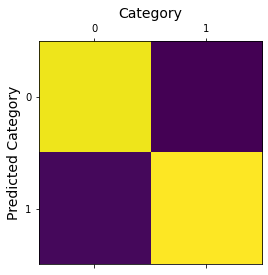

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       947
           1       0.95      0.97      0.96       951

    accuracy                           0.96      1898
   macro avg       0.96      0.96      0.96      1898
weighted avg       0.96      0.96      0.96      1898

60/60 - 0s - loss: 0.1223 - accuracy: 0.9594 - 120ms/epoch - 2ms/step
Test Loss: 0.12232336401939392
Test Accuracy: 0.959430992603302


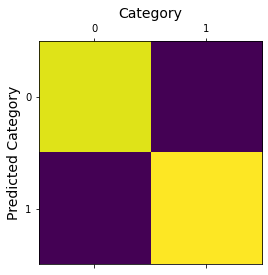

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       926
           1       0.96      0.96      0.96       972

    accuracy                           0.96      1898
   macro avg       0.96      0.96      0.96      1898
weighted avg       0.96      0.96      0.96      1898

60/60 - 0s - loss: 0.1106 - accuracy: 0.9521 - 125ms/epoch - 2ms/step
Test Loss: 0.11055293679237366
Test Accuracy: 0.9520547986030579


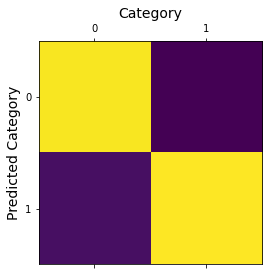

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       962
           1       0.94      0.97      0.95       936

    accuracy                           0.95      1898
   macro avg       0.95      0.95      0.95      1898
weighted avg       0.95      0.95      0.95      1898

60/60 - 0s - loss: 0.1155 - accuracy: 0.9610 - 112ms/epoch - 2ms/step
Test Loss: 0.1155407726764679
Test Accuracy: 0.9610115885734558


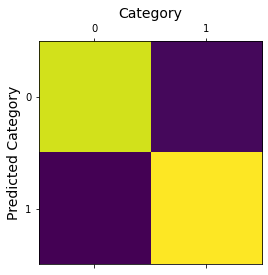

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       909
           1       0.97      0.95      0.96       989

    accuracy                           0.96      1898
   macro avg       0.96      0.96      0.96      1898
weighted avg       0.96      0.96      0.96      1898

60/60 - 0s - loss: 0.1208 - accuracy: 0.9510 - 162ms/epoch - 3ms/step
Test Loss: 0.12083180248737335
Test Accuracy: 0.9510010480880737


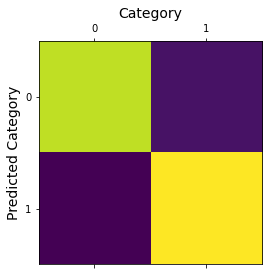

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       882
           1       0.98      0.93      0.95      1016

    accuracy                           0.95      1898
   macro avg       0.95      0.95      0.95      1898
weighted avg       0.95      0.95      0.95      1898

60/60 - 0s - loss: 0.1175 - accuracy: 0.9589 - 132ms/epoch - 2ms/step
Test Loss: 0.11746390163898468
Test Accuracy: 0.9589040875434875


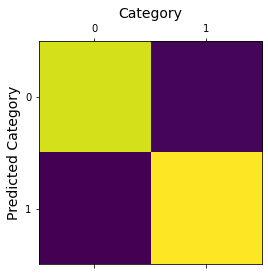

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       913
           1       0.97      0.95      0.96       985

    accuracy                           0.96      1898
   macro avg       0.96      0.96      0.96      1898
weighted avg       0.96      0.96      0.96      1898



In [7]:
for m in ms:
    test_loss, test_acc = m.evaluate(X_test,  y_test, verbose=2)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_acc)

    y_pred = np.argmax(m.predict(X_test), axis=-1)
    plt.matshow(confusion_matrix(y_test, y_pred, labels=[0,1]))
    plt.ylabel("Predicted Category", fontsize=14)
    plt.title("Category", fontsize=14)
    plt.show()
    print(classification_report(y_pred,y_test))

a
a
a
a
a
a


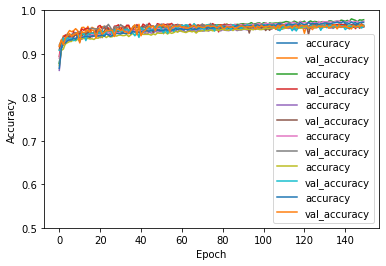

In [8]:
for i in range(len(hs)):
    plt.plot(hs[i].history['accuracy'], label='accuracy')
    plt.plot(hs[i].history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    print("a")


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

df= pd.read_csv('../feature_data/features.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


X = df.drop(["label"],axis=1)
X = X.drop(["radius"],axis=1)
cols = X.keys()

#normalize data
X = preprocessing.normalize(X, norm='max')

#labels
y = df["label"]
#idx = y == 0
#y[idx]=-1

X = pd.DataFrame(X, columns = cols)

X['label'] = y

#features
X = pd.DataFrame(X, columns = cols)



X_train, X_test, y_train, y_test= train_test_split(X,y,test_size= 0.3)


from sklearn.svm import OneClassSVM,SVC

rf= SVC(kernel = "poly", C=2000,verbose=True)

rf.fit(X_train,y_train)

predictions= rf.predict(X_test)
print(predictions[0:10])


from sklearn.metrics import classification_report, confusion_matrix


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[LibSVM].................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................*..............................................................................................................................